In [90]:
from scipy.spatial import Voronoi,Delaunay, ConvexHull
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [113]:
def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

In [114]:
def voronoi_area(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).area
    return vol

In [92]:
import MDAnalysis as mda

In [106]:
ih = mda.Universe("/home/dibyendu/DM_Projects/Sample_Structures/Ice/ice1h.gro", reset_offset = True)
liq = mda.Universe("/home/dibyendu/DM_Projects/Sample_Structures/Ice/liquid.gro", reset_offset = True)
ic = mda.Universe("/home/dibyendu/DM_Projects/Sample_Structures/Ice/ice1c.gro", reset_offset = True)
ice6 = mda.Universe("/home/dibyendu/DM_Projects/Sample_Structures/Ice/ice6.gro", reset_offset = True)
cs2 = mda.Universe("/home/dibyendu/DM_Projects/Sample_Structures/Ice/cs2.gro", reset_offset = True)

In [33]:
import seaborn as sns

In [83]:
@njit
def getMirrorBox(original, x, y, z):
    mirror = []
    count = 0
    for i in range(-1,2):
        for j in range(-1, 2):
            for k in range(-1, 2):
                if not (i == 0 and j == 0 and k == 0):
                    temp = original + np.array([i, j, k]) * np.array([x, y, z])
                    mirror.append(temp)
    center = original.mean(axis = 0)
    minimirror = []
    for box in mirror:
        thresx = x/2 + 10
        thresy = y/2 + 10 
        thresz = z/2 + 10 
        for particle in box:
            #distance = np.linalg.norm(center - particle)
            dx = center - particle

            if np.abs(dx[0]) < thresx: 
                if np.abs(dx[1]) < thresy:
                    if np.abs(dx[2]) < thresz:
                        minimirror.append(particle)
    return minimirror

In [117]:
def getGetVoronoiVolume(universe):
    points = universe.select_atoms("name OW").positions
    x, y, z = universe.dimensions[:3]
    mBox = getMirrorBox(points, x = x, y = y, z = z)
    all_data = np.zeros((len(points) + len(mBox), 3))
    all_data[:len(points)] = points
    all_data[len(points):] = np.array(mBox)
    vols = voronoi_volumes(all_data)
    areas = voronoi_area(all_data)
    return vols[:len(points)], areas[:len(points)]

In [122]:
#vliq, aliq = getGetVoronoiVolume(liq)
vih, aih = getGetVoronoiVolume(ih)
vic, aic = getGetVoronoiVolume(ic)

<AxesSubplot:ylabel='Density'>

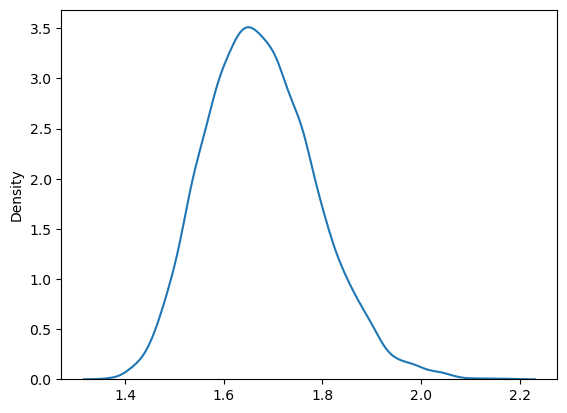

In [121]:
sns.kdeplot(aliq**3/ (36*np.pi*vliq**2))

In [123]:
vice6, aice6 = getGetVoronoiVolume(ice6)
vcs2, acs2 = getGetVoronoiVolume(cs2)

<AxesSubplot:ylabel='Density'>

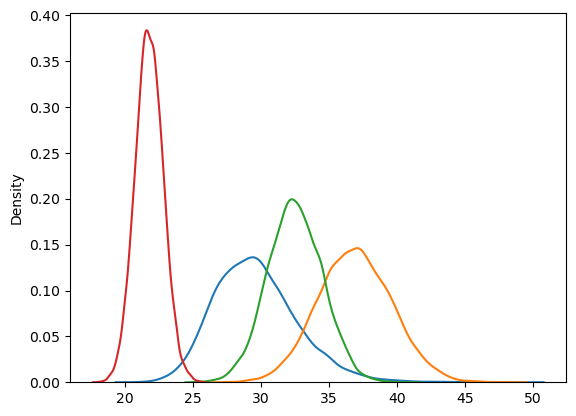

In [111]:
sns.kdeplot(vliq)
sns.kdeplot(vcs2)
sns.kdeplot(vih)
sns.kdeplot(vice6)

In [68]:
# Generation of the trajectory file
with open("temp.xyz", "w") as fn:
    # if prefer to output trajectories, open the output file
    fn.write(str(len(minimirror) + len(points))+'\n')
    fn.write(f'Step: {1} \n')
    for i_atom in range(len(points)):
        fn.write('Ar  ' + str(points[i_atom, 0]) +
                 '  ' + str(points[i_atom, 1]) +
                 '  ' + str(points[i_atom, 2]) +
                 '\n')
    for i_atom in range(len(minimirror)):
        fn.write('Ni  ' + str(minimirror[i_atom][0]) +
                 '  ' + str(minimirror[i_atom][1]) +
                 '  ' + str(minimirror[i_atom][2]) +
                 '\n')


In [82]:
x/3

23.091232299804688